<a href="https://colab.research.google.com/github/AIkikr/code-translation-pipeline-4/blob/main/%E8%A8%80%E8%AA%9E%E3%82%BF%E3%82%B9%E3%82%AF_%EF%BC%94__Ocean__XGLUE_%E8%A8%80%E8%AA%9E%E3%81%94%E3%81%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# python 3.10.12
!pip install -U pip
!pip install -U transformers
!pip install -U bitsandbytes
!pip install -U accelerate
!pip install -U datasets
!pip install -U peft
!pip install -U trl
!pip install -U wandb
!pip install ipywidgets --upgrade

In [2]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    logging,
)
from peft import (
    LoraConfig,
    PeftModel,
    get_peft_model,
)
import os, torch, gc
from datasets import load_dataset
import bitsandbytes as bnb
from trl import SFTTrainer

from transformers import DataCollatorForLanguageModeling


In [3]:
from google.colab import drive, files
from getpass import getpass
import os
from google.colab import userdata

hf_token = userdata.get('HF_TOKEN')

# トークンを環境変数に設定
os.environ['HUGGINGFACE_HUB_TOKEN'] = hf_token

# CLIにログイン
!huggingface-cli login --token $HUGGINGFACE_HUB_TOKEN

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
The token `HF_TOKEN` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `HF_TOKEN`


In [4]:
from IPython.display import Javascript
#JavaScriptコードを埋め込む
keep_alive_code = """
function keepColabAlive() {
    setInterval(() => {
        document.querySelector("colab-toolbar-button#connect").click();
    }, 600000); // 10分ごとにクリック
}
keepColabAlive();
"""

# JavaScriptを実行
display(Javascript(keep_alive_code))

<IPython.core.display.Javascript object>

In [5]:
# モデルを読み込み。
# llm-jp-3 1.8B, 3.7B, 13Bのsnapshotをダウンロード済みでmodelsディレクトリに格納してあります。
# base_model_idの値はomnicampusの環境におけるモデルのパスを表しており、それ以外の環境で実行する場合は変更の必要があります。
# その他のモデルは取得に承諾が必要なため、各自でダウンロードお願いします。
base_model_id = "microsoft/phi-4" #Fine-Tuningするベースモデル
# omnicampus以外の環境をご利用の方は以下をご利用ください。
# base_model_id = "llm-jp/llm-jp-3-13b"
new_model_id = "phi-4-4bit-Q-lora-kura-lang-3" #Fine-Tuningしたモデルにつけたい名前

In [6]:
from google.colab import drive
drive.mount('/content/drive')

# チェックポイント保存用のディレクトリを作成
!mkdir -p /content/drive/MyDrive/code_translation_project/checkpoints_5

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:

# Google Driveからデータセットをダウンロード
!pip install gdown
!gdown 1xw6Edqf_nknKoei_LC49n4EtvNQezKGe

# ダウンロードしたファイルを解凍
!unzip -q codetransocean_datasets.zip -d ./data
!ls -la

Downloading...
From (original): https://drive.google.com/uc?id=1xw6Edqf_nknKoei_LC49n4EtvNQezKGe
From (redirected): https://drive.google.com/uc?id=1xw6Edqf_nknKoei_LC49n4EtvNQezKGe&confirm=t&uuid=92631ac6-8ac5-464c-b807-94529636097d
To: /content/CodeTransOcean Datasets.zip
100% 132M/132M [00:02<00:00, 47.7MB/s]
unzip:  cannot find or open codetransocean_datasets.zip, codetransocean_datasets.zip.zip or codetransocean_datasets.zip.ZIP.
total 128880
drwxr-xr-x 1 root root      4096 Mar 23 08:48  .
drwxr-xr-x 1 root root      4096 Mar 22 22:34  ..
drwxr-xr-x 6 root root      4096 Oct 23  2023 'CodeTrans Datasets'
-rw-r--r-- 1 root root 131942209 Oct 24  2023 'CodeTransOcean Datasets.zip'
drwxr-xr-x 4 root root      4096 Mar 20 13:31  .config
drwx------ 6 root root      4096 Mar 22 22:49  drive
drwxr-xr-x 3 root root      4096 Mar 22 22:50  __MACOSX
drwxr-xr-x 1 root root      4096 Mar 20 13:31  sample_data


In [8]:
# ダウンロードしたZIPファイルを解凍
!unzip -q "CodeTransOcean Datasets.zip"

# 解凍後のディレクトリとファイルを確認
!ls -la

replace __MACOSX/._CodeTrans Datasets? [y]es, [n]o, [A]ll, [N]one, [r]ename: total 128880
drwxr-xr-x 1 root root      4096 Mar 23 08:48  .
drwxr-xr-x 1 root root      4096 Mar 22 22:34  ..
drwxr-xr-x 6 root root      4096 Oct 23  2023 'CodeTrans Datasets'
-rw-r--r-- 1 root root 131942209 Oct 24  2023 'CodeTransOcean Datasets.zip'
drwxr-xr-x 4 root root      4096 Mar 20 13:31  .config
drwx------ 6 root root      4096 Mar 22 22:49  drive
drwxr-xr-x 3 root root      4096 Mar 22 22:50  __MACOSX
drwxr-xr-x 1 root root      4096 Mar 20 13:31  sample_data


In [9]:
# データセットディレクトリの内容を確認
!ls -la "CodeTrans Datasets"

total 36
drwxr-xr-x 6 root root 4096 Oct 23  2023 .
drwxr-xr-x 1 root root 4096 Mar 23 08:48 ..
drwxr-xr-x 2 root root 4096 Oct 23  2023 DLTrans
-rw-rw-r-- 1 root root 8196 Oct 23  2023 .DS_Store
drwxrwxr-x 2 root root 4096 Aug 28  2023 LLMTrans
drwxr-xr-x 2 root root 4096 Oct 23  2023 MultilingualTrans
drwxr-xr-x 2 root root 4096 Oct 23  2023 NicheTrans


In [10]:
# MultilingualTransディレクトリの内容を確認
!ls -la "CodeTrans Datasets/MultilingualTrans"

total 151188
drwxr-xr-x 2 root root     4096 Oct 23  2023 .
drwxr-xr-x 6 root root     4096 Oct 23  2023 ..
-rw-rw-r-- 1 root root 44466928 May 28  2023 multilingual_test.json
-rw-rw-r-- 1 root root 91702782 May 28  2023 multilingual_train.json
-rw-rw-r-- 1 root root 18623972 May 28  2023 multilingual_valid.json


In [11]:
# ファイルの最初の数行を読み込み、構造を確認
import json

# トレーニングファイルの構造を確認
train_file = "CodeTrans Datasets/MultilingualTrans/multilingual_train.json"
with open(train_file, 'r', encoding='utf-8') as file:
    first_line = file.readline().strip()
    item = json.loads(first_line)
    print("ファイル内の最初のエントリのキー:", list(item.keys()))
    print("言語キーの例：", [key for key in item.keys() if key not in ["id", "name"]])

    # 言語サンプルを表示（最初のいくつかの文字）
    for lang_key in [key for key in item.keys() if key not in ["id", "name"]]:
        print(f"\n{lang_key} サンプル (先頭100文字):")
        print(item[lang_key][:100])

ファイル内の最初のエントリのキー: ['id', 'name', 'C', 'C#']
言語キーの例： ['C', 'C#']

C サンプル (先頭100文字):
#include<graphics.h>
#include<stdlib.h>
#include<math.h>

typedef struct{
	double x,y;
}complex;

co

C# サンプル (先頭100文字):
using System.Drawing;



using System.Linq;

namespace RosettaJuliaSet
{
    class Program
    {
   


In [12]:
# ファイル全体のすべての言語キーを収集
def collect_all_language_keys(file_path):
    all_keys = set()
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            try:
                item = json.loads(line.strip())
                # id や name のような非言語キーを除外
                keys = [key for key in item.keys() if key not in ["id", "name"]]
                all_keys.update(keys)
            except json.JSONDecodeError:
                continue
    return sorted(list(all_keys))

# すべての言語キーを収集
all_language_keys = collect_all_language_keys(train_file)
print("データセット内のすべての言語キー:", all_language_keys)

# すべての可能な言語ペアを作成
all_pairs = []
for i, source in enumerate(all_language_keys):
    for target in all_language_keys:
        if source != target:
            all_pairs.append((source, target))

print("\n生成した言語ペア (最初の10ペア):", all_pairs[:10])
print(f"合計言語ペア数: {len(all_pairs)}")

データセット内のすべての言語キー: ['C', 'C#', 'C++', 'Go', 'Java', 'PHP', 'Python', 'VB']

生成した言語ペア (最初の10ペア): [('C', 'C#'), ('C', 'C++'), ('C', 'Go'), ('C', 'Java'), ('C', 'PHP'), ('C', 'Python'), ('C', 'VB'), ('C#', 'C'), ('C#', 'C++'), ('C#', 'Go')]
合計言語ペア数: 56


In [13]:
# JSONLファイルからデータセットを読み込む関数
def load_jsonl_dataset(file_path, lang_pairs):
    """JSONLファイルからデータセットを読み込む関数"""
    import json
    import pandas as pd
    from datasets import Dataset, DatasetDict

    all_data = {f"{source}_to_{target}": [] for source, target in lang_pairs}

    # ファイルを行ごとに読み込む
    line_count = 0
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            try:
                item = json.loads(line.strip())
                line_count += 1

                # 各言語ペアに対してデータを収集
                for source, target in lang_pairs:
                    if source in item and target in item:
                        all_data[f"{source}_to_{target}"].append({
                            "source_code": item[source],
                            "target_code": item[target],
                            "source_lang": source,
                            "target_lang": target
                        })
            except json.JSONDecodeError:
                print(f"JSONデコードエラー: {line[:50]}...")
                continue

    print(f"処理した行数: {line_count}")

    # DatasetDict形式に変換
    result = {}
    for pair_name, data_list in all_data.items():
        if data_list:
            result[pair_name] = Dataset.from_pandas(pd.DataFrame(data_list))
            print(f"言語ペア {pair_name} のデータを読み込みました: {len(data_list)} サンプル")

    return DatasetDict(result)

# 選択した言語ペアでデータセットを読み込む
selected_pairs = [
    ("C++", "Python"),
    ("Python", "C++"),
    ("Java", "Python"),
    ("Python", "Java"),
    ("C#", "Python"),
    ("Python", "C#")
]

# トレーニングとテストのファイルパスが正しいことを確認
train_file = "CodeTrans Datasets/MultilingualTrans/multilingual_train.json"
test_file = "CodeTrans Datasets/MultilingualTrans/multilingual_test.json"

print("\n選択した言語ペア:", selected_pairs)
train_dataset = load_jsonl_dataset(train_file, selected_pairs)
test_dataset = load_jsonl_dataset(test_file, selected_pairs)


選択した言語ペア: [('C++', 'Python'), ('Python', 'C++'), ('Java', 'Python'), ('Python', 'Java'), ('C#', 'Python'), ('Python', 'C#')]
処理した行数: 38230
言語ペア C++_to_Python のデータを読み込みました: 1684 サンプル
言語ペア Python_to_C++ のデータを読み込みました: 1684 サンプル
言語ペア Java_to_Python のデータを読み込みました: 1676 サンプル
言語ペア Python_to_Java のデータを読み込みました: 1676 サンプル
言語ペア C#_to_Python のデータを読み込みました: 1626 サンプル
言語ペア Python_to_C# のデータを読み込みました: 1626 サンプル
処理した行数: 15090
言語ペア C++_to_Python のデータを読み込みました: 810 サンプル
言語ペア Python_to_C++ のデータを読み込みました: 810 サンプル
言語ペア Java_to_Python のデータを読み込みました: 872 サンプル
言語ペア Python_to_Java のデータを読み込みました: 872 サンプル
言語ペア C#_to_Python のデータを読み込みました: 398 サンプル
言語ペア Python_to_C# のデータを読み込みました: 398 サンプル


In [14]:
# 以下のコードは「print("\n選択した言語ペア:", selected_pairs)」の後に挿入

# 必要なライブラリを確実にインポート
!pip install -q datasets pandas tqdm

# インポート文を正しく記載
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets
import pandas as pd
from tqdm import tqdm

# 追加データセットのための新しい言語ペアを定義
# CodeXGLUEデータセットではJavaとC#のみが利用可能なため、それらの言語ペアを追加
additional_pairs = [
    ("Java", "C#"),
    ("C#", "Java")
]

# 元の言語ペアと追加言語ペアを結合
extended_pairs = selected_pairs + additional_pairs
print("拡張言語ペア:", extended_pairs)

# CodeXGLUE TransCoderデータセットをHugging Faceから取得
print("CodeXGLUEのデータセットをロード中...")

# CodeXGLUEのTransCoderデータセットを読み込む
try:
    codexglue_dataset = load_dataset("google/code_x_glue_cc_code_to_code_trans")
    print(f"CodeXGLUEデータセットをロードしました: {codexglue_dataset}")
except Exception as e:
    print(f"CodeXGLUEデータセット読み込みエラー: {e}")
    codexglue_dataset = None

# CodeXGLUEのデータを変換する関数
def convert_codexglue_format(dataset):
    """CodeXGLUEデータセットをCodeTransOcean形式に変換"""
    if dataset is None:
        return None

    # 言語マッピング（CodeXGLUEの言語名をCodeTransOceanの形式に合わせる）
    lang_mapping = {
        "java": "Java",
        "cs": "C#"
    }

    # 変換結果を格納する辞書
    converted_pairs = {}

    # データセットの構造を確認
    first_item = next(iter(dataset['train']))
    available_langs = [key for key in first_item.keys() if key != 'id']
    print(f"利用可能な言語: {available_langs}")

    # 各スプリット（train, validation, test）を処理
    for split_name in dataset:
        split_data = dataset[split_name]
        print(f"処理中のスプリット: {split_name}, サンプル数: {len(split_data)}")

        # このスプリットの変換データを格納
        converted_split = {}

        # 言語ペア用のデータを初期化
        for source_lang in available_langs:
            s_lang = lang_mapping[source_lang]
            for target_lang in available_langs:
                if source_lang != target_lang:
                    t_lang = lang_mapping[target_lang]
                    pair_key = f"{s_lang}_to_{t_lang}"
                    converted_split[pair_key] = []

        # 各サンプルから言語ペアを生成
        for item in tqdm(split_data, desc=f"変換中 {split_name}"):
            for source_lang in available_langs:
                s_lang = lang_mapping[source_lang]
                for target_lang in available_langs:
                    if source_lang != target_lang:
                        t_lang = lang_mapping[target_lang]
                        pair_key = f"{s_lang}_to_{t_lang}"

                        converted_split[pair_key].append({
                            "source_code": item[source_lang],
                            "target_code": item[target_lang],
                            "source_lang": s_lang,
                            "target_lang": t_lang
                        })

        # データセットに変換
        pair_datasets = {}
        for pair_key, items in converted_split.items():
            if items:
                pair_datasets[pair_key] = Dataset.from_pandas(pd.DataFrame(items))
                print(f"{split_name} データ {pair_key}: {len(items)} サンプル")

        # 変換結果に追加
        converted_pairs[split_name] = pair_datasets

    return converted_pairs

# CodeXGLUEデータセットを変換
if codexglue_dataset:
    print("CodeXGLUEデータセットを変換中...")
    codexglue_converted = convert_codexglue_format(codexglue_dataset)
else:
    codexglue_converted = None

# 元のCodeTransOceanデータセットを読み込む
print("CodeTransOceanデータセットを読み込み中...")
train_dataset = load_jsonl_dataset(train_file, extended_pairs)
test_dataset = load_jsonl_dataset(test_file, extended_pairs)

# 元のCodeTransOceanデータセットから検証データを作成する関数
def create_validation_split(dataset_dict, validation_ratio=0.1, random_seed=42):
    """
    各言語ペアのデータセットから一定割合を検証用データとして分割する

    Parameters:
    -----------
    dataset_dict : DatasetDict
        元のデータセット辞書
    validation_ratio : float
        検証用に分割する割合 (0-1)
    random_seed : int
        乱数シード

    Returns:
    --------
    train_dict : DatasetDict
        分割後のトレーニングデータセット辞書
    validation_dict : DatasetDict
        分割後の検証用データセット辞書
    """
    train_dict = {}
    validation_dict = {}

    for pair_key, dataset in dataset_dict.items():
        # データセットをシャッフルしてからトレーニングと検証に分割
        shuffled_dataset = dataset.shuffle(seed=random_seed)
        split_datasets = shuffled_dataset.train_test_split(
            test_size=validation_ratio,
            seed=random_seed
        )

        # 分割結果をそれぞれの辞書に格納
        train_dict[pair_key] = split_datasets['train']
        validation_dict[f"{pair_key}_validation"] = split_datasets['test']

        print(f"{pair_key}: {len(dataset)} → トレーニング {len(split_datasets['train'])}, 検証 {len(split_datasets['test'])}")

    return train_dict, validation_dict

# CodeTransOceanデータセットから検証データを分割
print("\nCodeTransOceanデータセットから検証データを作成...")
train_datasets, validation_datasets = create_validation_split(
    train_dataset,
    validation_ratio=0.1,  # 10%を検証用に分割
    random_seed=42
)

# データセットを統合する
if codexglue_converted and "train" in codexglue_converted:
    print("\nCodeXGLUEデータセットとの統合を開始します...")

    # CodeXGLUEデータセットのトレーニングデータを統合
    for pair_key, dataset in codexglue_converted["train"].items():
        if pair_key in train_datasets:
            # 既存の言語ペアにデータを追加
            original_size = len(train_datasets[pair_key])
            train_datasets[pair_key] = concatenate_datasets([
                train_datasets[pair_key],
                dataset
            ])
            new_size = len(train_datasets[pair_key])
            print(f"トレーニング {pair_key}: {original_size} → {new_size} サンプルに増加 (+{new_size - original_size})")
        else:
            # 新しい言語ペアを追加
            train_datasets[pair_key] = dataset
            print(f"新しいトレーニングペア {pair_key}: {len(dataset)} サンプル追加")

    # CodeXGLUEデータセットの検証データを統合
    if "validation" in codexglue_converted:
        for pair_key, dataset in codexglue_converted["validation"].items():
            validation_key = f"{pair_key}_validation"
            if validation_key in validation_datasets:
                # 既存の検証データに追加
                original_size = len(validation_datasets[validation_key])
                validation_datasets[validation_key] = concatenate_datasets([
                    validation_datasets[validation_key],
                    dataset
                ])
                new_size = len(validation_datasets[validation_key])
                print(f"検証 {validation_key}: {original_size} → {new_size} サンプルに増加 (+{new_size - original_size})")
            else:
                # 新しい検証データを追加
                validation_datasets[validation_key] = dataset
                print(f"新しい検証ペア {validation_key}: {len(dataset)} サンプル追加")

# 全てのデータセットを最終的な辞書に統合
final_datasets = {}

# トレーニングデータを追加
for pair_key, dataset in train_datasets.items():
    final_datasets[pair_key] = dataset

# 検証データを追加
for validation_key, dataset in validation_datasets.items():
    final_datasets[validation_key] = dataset

# テストデータを追加
for pair_key, dataset in test_dataset.items():
    test_key = f"{pair_key}_test"
    final_datasets[test_key] = dataset
    print(f"テストデータ {test_key}: {len(dataset)} サンプル")

# データ量の多い言語ペアをサンプリング
print("\nデータ量の多い言語ペアをサンプリングします...")
# サンプリング対象の言語ペア
sampling_pairs = ["Java_to_C#", "C#_to_Java"]
max_samples = 5000

# データセットをサンプリング
for pair_key in sampling_pairs:
    if pair_key in final_datasets and len(final_datasets[pair_key]) > max_samples:
        original_size = len(final_datasets[pair_key])
        # ランダムにサンプリング
        sampled_dataset = final_datasets[pair_key].shuffle(seed=42).select(range(max_samples))
        final_datasets[pair_key] = sampled_dataset
        print(f"  {pair_key}: {original_size} → {max_samples} サンプルに削減 (-{original_size - max_samples})")

# 最終的なデータセットサイズを表示
print("\n統合後の最終データセット:")
total_samples = {"train": 0, "validation": 0, "test": 0}

for key, dataset in final_datasets.items():
    samples = len(dataset)
    if "_validation" in key:
        dataset_type = "validation"
    elif "_test" in key:
        dataset_type = "test"
    else:
        dataset_type = "train"

    total_samples[dataset_type] += samples
    print(f"  {key}: {samples} サンプル")

print(f"\n合計: トレーニング {total_samples['train']}, 検証 {total_samples['validation']}, テスト {total_samples['test']} サンプル")

# train_datasetを新しいデータセットで置き換え
train_dataset = DatasetDict(final_datasets)

拡張言語ペア: [('C++', 'Python'), ('Python', 'C++'), ('Java', 'Python'), ('Python', 'Java'), ('C#', 'Python'), ('Python', 'C#'), ('Java', 'C#'), ('C#', 'Java')]
CodeXGLUEのデータセットをロード中...
CodeXGLUEデータセットをロードしました: DatasetDict({
    train: Dataset({
        features: ['id', 'java', 'cs'],
        num_rows: 10300
    })
    validation: Dataset({
        features: ['id', 'java', 'cs'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'java', 'cs'],
        num_rows: 1000
    })
})
CodeXGLUEデータセットを変換中...
利用可能な言語: ['java', 'cs']
処理中のスプリット: train, サンプル数: 10300


変換中 train: 100%|██████████| 10300/10300 [00:00<00:00, 30070.42it/s]


train データ Java_to_C#: 10300 サンプル
train データ C#_to_Java: 10300 サンプル
処理中のスプリット: validation, サンプル数: 500


変換中 validation: 100%|██████████| 500/500 [00:00<00:00, 27900.65it/s]


validation データ Java_to_C#: 500 サンプル
validation データ C#_to_Java: 500 サンプル
処理中のスプリット: test, サンプル数: 1000


変換中 test: 100%|██████████| 1000/1000 [00:00<00:00, 29997.24it/s]


test データ Java_to_C#: 1000 サンプル
test データ C#_to_Java: 1000 サンプル
CodeTransOceanデータセットを読み込み中...
処理した行数: 38230
言語ペア C++_to_Python のデータを読み込みました: 1684 サンプル
言語ペア Python_to_C++ のデータを読み込みました: 1684 サンプル
言語ペア Java_to_Python のデータを読み込みました: 1676 サンプル
言語ペア Python_to_Java のデータを読み込みました: 1676 サンプル
言語ペア C#_to_Python のデータを読み込みました: 1626 サンプル
言語ペア Python_to_C# のデータを読み込みました: 1626 サンプル
言語ペア Java_to_C# のデータを読み込みました: 1500 サンプル
言語ペア C#_to_Java のデータを読み込みました: 1500 サンプル
処理した行数: 15090
言語ペア C++_to_Python のデータを読み込みました: 810 サンプル
言語ペア Python_to_C++ のデータを読み込みました: 810 サンプル
言語ペア Java_to_Python のデータを読み込みました: 872 サンプル
言語ペア Python_to_Java のデータを読み込みました: 872 サンプル
言語ペア C#_to_Python のデータを読み込みました: 398 サンプル
言語ペア Python_to_C# のデータを読み込みました: 398 サンプル
言語ペア Java_to_C# のデータを読み込みました: 348 サンプル
言語ペア C#_to_Java のデータを読み込みました: 348 サンプル

CodeTransOceanデータセットから検証データを作成...
C++_to_Python: 1684 → トレーニング 1515, 検証 169
Python_to_C++: 1684 → トレーニング 1515, 検証 169
Java_to_Python: 1676 → トレーニング 1508, 検証 168
Python_to_Java: 1676 → トレーニング 1508, 検証 168
C#_to_P

In [15]:
# 量子化設定
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# モデルとトークナイザーを読み込む
model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    quantization_config=bnb_config,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(base_model_id, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

In [16]:
# LoRA適用モジュールを特定する関数
def find_all_linear_names(model):
    cls = bnb.nn.Linear4bit
    lora_module_names = set()

    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names:
        lora_module_names.remove('lm_head')

    return list(lora_module_names)

modules = find_all_linear_names(model)

In [17]:
# LoRA設定
peft_config = LoraConfig(
    r=4,
    lora_alpha=8,
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=modules
)

# LoRAをモデルに適用
model = get_peft_model(model, peft_config)




In [18]:
base_model_id = "microsoft/phi-4"
tokenizer = AutoTokenizer.from_pretrained(base_model_id, trust_remote_code=True)

# プロンプトの定義
prompt = """### Instruction
Translate from {source_lang} to {target_lang}:
{source_code}

### Translation
{target_code}"""

EOS_TOKEN = tokenizer.eos_token

In [19]:
def format_data(examples):
    inputs = [
        prompt.format(
            source_lang=source_lang,
            target_lang=target_lang,
            source_code=source_code,
            target_code=target_code
        ) + EOS_TOKEN
        for source_code, target_code, source_lang, target_lang in zip(
            examples["source_code"],
            examples["target_code"],
            examples["source_lang"],
            examples["target_lang"]
        )
    ]
    return tokenizer(inputs, max_length=512, padding="max_length", truncation=True)

In [20]:
from datasets import concatenate_datasets

# 統合された単一のデータセットを作成
train_dataset_all = concatenate_datasets([ds for ds in train_dataset.values()])
test_dataset_all = concatenate_datasets([ds for ds in test_dataset.values()])

# 統合後に前処理
train_dataset_processed = train_dataset_all.map(
    format_data,
    batched=True,
    remove_columns=["source_code", "target_code", "source_lang", "target_lang"]
)

test_dataset_processed = test_dataset_all.map(
    format_data,
    batched=True,
    remove_columns=["source_code", "target_code", "source_lang", "target_lang"]
)


Map:   0%|          | 0/26128 [00:00<?, ? examples/s]

Map:   0%|          | 0/4856 [00:00<?, ? examples/s]

In [ ]:
# 学習設定
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/code_translation_project/checkpoints",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    optim="paged_adamw_32bit",
    num_train_epochs=1,
    logging_steps=10,
    warmup_steps=20,
    save_steps=100,
    save_total_limit=2,
    learning_rate=2e-5,
    fp16=False,
    bf16=True,
    group_by_length=True,
    report_to="none"
)

In [ ]:
# SFTTrainerを使用したFine-Tuning
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset_processed,
    eval_dataset=test_dataset_processed,
    peft_config=peft_config,
    args=training_args,
    data_collator=DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False
    )
)

Converting train dataset to ChatML:   0%|          | 0/26128 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/26128 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/26128 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/4856 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/4856 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/4856 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)


In [ ]:
# キャッシュを無効にして学習を開始
model.config.use_cache = False
trainer.train()

Step,Training Loss
10,0.542400
20,0.583400
30,0.596200
40,0.581900
50,0.512900
60,0.500100
70,0.508900
80,0.577200
90,0.565800
100,0.493000


Step,Training Loss
10,0.542400
20,0.583400
30,0.596200
40,0.581900
50,0.512900
60,0.500100
70,0.508900
80,0.577200
90,0.565800
100,0.493000


In [ ]:
# Google Driveのマウント
from google.colab import drive
import os
from google.colab import userdata

# ドライブをマウント
drive.mount('/content/drive', force_remount=True)


# Hugging Faceトークンの取得
try:
    hf_token = userdata.get('HF_TOKEN')
    os.environ['HUGGINGFACE_HUB_TOKEN'] = hf_token
except Exception as e:
    print(f"トークン取得エラー: {e}")
    # 手動入力のバックアップ方法
    from getpass import getpass
    hf_token = getpass("Hugging Faceトークンを入力してください: ")

# CLIにログイン
!huggingface-cli login --token $HUGGINGFACE_HUB_TOKEN

Mounted at /content/drive
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
The token `HF_TOKEN` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `HF_TOKEN`


In [22]:
pip install safetensors datasets

In [23]:
!pip install sacrebleu

In [ ]:

# 出力ディレクトリをGoogleドライブに変更
training_args.output_dir = "/content/drive/MyDrive/phi_code_translator"

In [ ]:
# モデルの保存
trainer.save_model("/content/drive/MyDrive/phi_code_translator/final_model_2")

In [ ]:
pip install --upgrade evaluate

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

config.json:   0%|          | 0.00/802 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.4k [00:00<?, ?B/s]

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

model-00004-of-00006.safetensors:   0%|          | 0.00/4.77G [00:00<?, ?B/s]

model-00001-of-00006.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00006-of-00006.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00006.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00005-of-00006.safetensors:   0%|          | 0.00/4.77G [00:00<?, ?B/s]

model-00002-of-00006.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

評価用データ準備完了: 4856 サンプル
包括的評価を開始します...
言語ペアごとのサンプル数:
  Java_to_Python: 872 サンプル
  Python_to_Java: 872 サンプル

評価中: Java_to_Python (872 サンプル)
  サンプル数を 100 に制限します

評価中: Python_to_Java (872 サンプル)
  サンプル数を 100 に制限します
グラフを /content/drive/MyDrive/code_translation_project/language_pair_results.png に保存しました
データを /content/drive/MyDrive/code_translation_project/language_pair_results.csv に保存しました
評価結果を /content/drive/MyDrive/code_translation_project/evaluation_results/evaluation_results_20250323_064329.json に保存しました

全体のBLEUスコア: {'bleu': 62.19834163303356}

言語ペアごとのBLEUスコア:
  Java_to_Python: 51.85 (100 サンプル)
  Python_to_Java: 69.74 (100 サンプル)

代表的な例 (C++_to_Python):


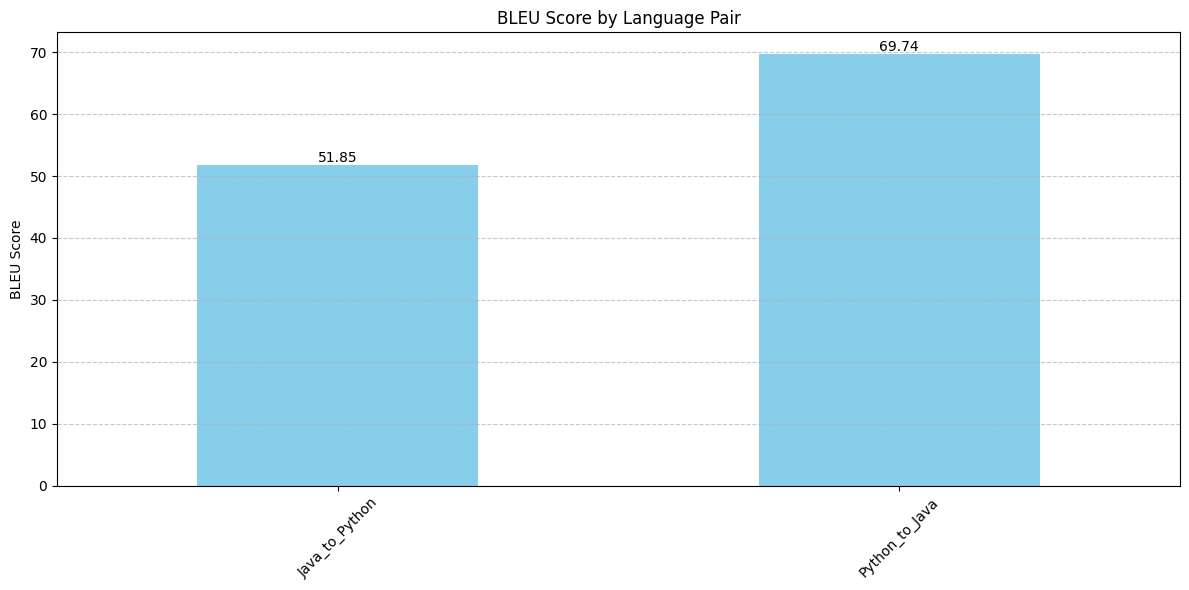

In [24]:
import torch
import gc
import random
import warnings
import sacrebleu
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel
from google.colab import output

# メモリ解放と最適化の関数
def free_memory():
    torch.cuda.empty_cache()
    gc.collect()

# 警告の非表示と初期メモリ解放
warnings.filterwarnings('ignore', category=UserWarning)
free_memory()

# Colabのウィジェットマネージャーを有効化
output.enable_custom_widget_manager()

# ベースモデル名
base_model_id = "microsoft/phi-4"

# 4ビット量子化の設定（メモリ効率化）
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True  # さらなるメモリ削減
)

# デバイスマップの設定
device_map = {
    "": 0,  # すべてのレイヤーをGPU 0に
    "lm_head": 0
}

# モデルとトークナイザーの読み込み（メモリ効率化）
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    quantization_config=bnb_config,
    device_map=device_map,
    low_cpu_mem_usage=True
)

tokenizer = AutoTokenizer.from_pretrained(base_model_id, padding_side="left")

# トークナイザーの追加設定
tokenizer.pad_token = tokenizer.eos_token

# LoRAアダプターのリポジトリ名
lora_model_name = "AkiK/phi-4-4bit-Q-lora-kura-lang-3"

# PeftModelとしてLoRAアダプターを読み込み
try:
    model = PeftModel.from_pretrained(
        base_model,
        lora_model_name,
        is_trainable=False,
        device_map=device_map
    )
except Exception as e:
    print(f"アダプター読み込みエラー: {e}")
    model = base_model

# モデルの最終準備
model.eval()  # 評価モードに
model = model.to('cuda')
free_memory()

# BLEU計算用の関数
def calculate_bleu(predictions, references):
    references_list = [[ref] for ref in references]
    bleu = sacrebleu.corpus_bleu(predictions, references_list)
    return {"bleu": bleu.score}

# 予測と評価の関数（バッチ処理とメモリ効率化）
def generate_and_evaluate(model, tokenizer, test_data, num_samples=50, batch_size=4):
    # ランダムサンプリング
    random.seed(42)
    test_data = random.sample(test_data, min(num_samples, len(test_data)))

    predictions = []
    references = []

    # バッチ処理
    for i in range(0, len(test_data), batch_size):
        batch_data = test_data[i:i+batch_size]
        batch_prompts = [item["prompt"] for item in batch_data]

        # バッチでのトークン化
        inputs = tokenizer(
            batch_prompts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        ).to(model.device)

        # バッチでの生成
        with torch.no_grad():
            try:
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=512,  # トークン数削減
                    temperature=0.2,
                    do_sample=True,
                    top_p=0.95,
                    repetition_penalty=1.1,
                    num_return_sequences=1
                )
            except RuntimeError as e:
                print(f"生成中にエラー: {e}")
                free_memory()
                continue

        # バッチ処理の結果を処理
        for j, output in enumerate(outputs):
            try:
                generated_text = tokenizer.decode(output, skip_special_tokens=True)
                prompt_length = len(batch_data[j]["prompt"])
                predicted_code = generated_text[prompt_length:].strip()

                # コードブロック抽出
                code_markers = ["```python", "```cpp", "```java", "```cs", "```c#", "```"]
                for marker in code_markers:
                    if marker in predicted_code:
                        predicted_code = predicted_code.split(marker)[1].split("```")[0].strip()
                        break

                predictions.append(predicted_code)
                references.append(batch_data[j]["target"])
            except Exception as e:
                print(f"コード抽出中にエラー: {e}")

        # 各バッチ後にメモリを解放
        free_memory()

    # BLEUスコアの計算
    bleu_score = calculate_bleu(predictions, references)

    return bleu_score, predictions, references

# テストデータの準備
# テストデータの準備
test_dataset_with_prompt = []

# final_datasetsからテストデータを抽出
test_keys = [key for key in final_datasets.keys() if "_test" in key]

for key in test_keys:
    dataset = final_datasets[key]
    for item in dataset:
        # プロンプトの形式を合わせる
        prompt = f"""### Instruction
Translate from {item['source_lang']} to {item['target_lang']}:
{item['source_code']}

### Translation"""

        test_dataset_with_prompt.append({
            "prompt": prompt,
            "target": item['target_code']
        })

print(f"評価用データ準備完了: {len(test_dataset_with_prompt)} サンプル")

# 言語ペアごとの評価を行う関数
def evaluate_by_language_pair(model, tokenizer, test_dataset_with_prompt, pair_info):
    """
    言語ペアごとに評価を実行する関数

    Parameters:
    -----------
    model : PeftModel
        評価対象のモデル
    tokenizer : AutoTokenizer
        トークナイザー
    test_dataset_with_prompt : list
        テストデータのリスト（プロンプト付き）
    pair_info : dict
        言語ペアの情報（キー: 言語ペア名, 値: 該当するサンプルのインデックスリスト）

    Returns:
    --------
    dict
        言語ペアごとの評価結果
    """
    results = {}

    for pair_name, indices in pair_info.items():
        if not indices:  # インデックスが空の場合はスキップ
            continue

        print(f"\n評価中: {pair_name} ({len(indices)} サンプル)")

        # このペアのテストデータを抽出
        pair_test_data = [test_dataset_with_prompt[i] for i in indices]

        # サンプル数が多すぎる場合は制限（オプション）
        max_samples = min(len(pair_test_data), 100)  # 最大100サンプル
        if len(pair_test_data) > max_samples:
            pair_test_data = random.sample(pair_test_data, max_samples)
            print(f"  サンプル数を {max_samples} に制限します")

        # このペアのBLEUスコアを計算
        pair_bleu, pair_predictions, pair_references = generate_and_evaluate(
            model,
            tokenizer,
            pair_test_data,
            num_samples=len(pair_test_data),  # すべてのサンプルを使用
            batch_size=4
        )

        # 代表的なサンプルを取得
        examples = get_representative_examples(
            pair_predictions,
            pair_references,
            pair_test_data
        )

        # 結果を保存
        results[pair_name] = {
            "bleu": pair_bleu,
            "num_samples": len(pair_test_data),
            "examples": examples
        }

    return results

# 代表的なサンプル（良いもの、悪いもの、平均的なもの）を選択する関数
def get_representative_examples(predictions, references, test_data, num_examples=3):
    """
    代表的なサンプル（最良、最悪、平均的）を選択する

    Parameters:
    -----------
    predictions : list
        予測結果のリスト
    references : list
        正解のリスト
    test_data : list
        テストデータのリスト
    num_examples : int, optional
        各カテゴリから取得する例の数

    Returns:
    --------
    dict
        代表的なサンプルの情報
    """
    # 個別のBLEUスコアを計算
    individual_scores = []
    for i, (pred, ref) in enumerate(zip(predictions, references)):
        # 空の予測や参照の場合は0点を付ける
        if not pred or not ref:
            individual_scores.append(0)
            continue

        # 単純な単語マッチングベースのスコア（簡易版）
        pred_words = set(pred.split())
        ref_words = set(ref.split())

        if not ref_words:  # 参照が空の場合
            individual_scores.append(0)
            continue

        # 一致する単語の割合を計算
        overlap = len(pred_words.intersection(ref_words))
        precision = overlap / len(pred_words) if pred_words else 0
        recall = overlap / len(ref_words) if ref_words else 0

        # F1スコアを計算（0~1の範囲）
        if precision + recall > 0:
            f1 = 2 * precision * recall / (precision + recall)
        else:
            f1 = 0

        individual_scores.append(f1)

    # スコアでソート
    indexed_scores = [(i, score) for i, score in enumerate(individual_scores)]
    sorted_scores = sorted(indexed_scores, key=lambda x: x[1])

    if not sorted_scores:
        return {"best": {}, "average": {}, "worst": {}}

    result = {}

    # 最良のサンプル
    best_indices = [idx for idx, score in sorted_scores[-num_examples:]]
    result["best"] = [
        {
            "prompt": test_data[idx]["prompt"],
            "prediction": predictions[idx],
            "reference": references[idx],
            "score": individual_scores[idx]
        }
        for idx in best_indices
    ]

    # 最悪のサンプル
    worst_indices = [idx for idx, score in sorted_scores[:num_examples]]
    result["worst"] = [
        {
            "prompt": test_data[idx]["prompt"],
            "prediction": predictions[idx],
            "reference": references[idx],
            "score": individual_scores[idx]
        }
        for idx in worst_indices
    ]

    # 平均的なサンプル
    middle_idx = len(sorted_scores) // 2
    middle_indices = [idx for idx, score in sorted_scores[middle_idx-num_examples//2:middle_idx+num_examples//2+1]]
    result["average"] = [
        {
            "prompt": test_data[idx]["prompt"],
            "prediction": predictions[idx],
            "reference": references[idx],
            "score": individual_scores[idx]
        }
        for idx in middle_indices
    ]

    return result

# 言語ペアをプロンプトから抽出する関数
def extract_language_pairs(test_dataset):
    """
    テストデータセットから言語ペアを抽出し、各ペアに対応するインデックスを返す

    Parameters:
    -----------
    test_dataset : list
        テストデータのリスト

    Returns:
    --------
    dict
        言語ペアごとのインデックスのディクショナリ
    """
    import re

    pair_indices = {}

    for i, item in enumerate(test_dataset):
        prompt = item["prompt"]
        # 正規表現でソース言語とターゲット言語を抽出
        match = re.search(r"Translate from (\w+) to (\w+):", prompt)
        if match:
            source_lang = match.group(1)
            target_lang = match.group(2)
            pair_name = f"{source_lang}_to_{target_lang}"

            if pair_name not in pair_indices:
                pair_indices[pair_name] = []

            pair_indices[pair_name].append(i)

    # 各言語ペアのサンプル数を表示
    print("言語ペアごとのサンプル数:")
    for pair, indices in pair_indices.items():
        print(f"  {pair}: {len(indices)} サンプル")

    return pair_indices

# 評価結果を可視化する関数
def visualize_results(results):
    """
    言語ペアごとの評価結果を可視化する

    Parameters:
    -----------
    results : dict
        言語ペアごとの評価結果

    Returns:
    --------
    None
    """
    import matplotlib.pyplot as plt
    import pandas as pd

    # BLEUスコアをデータフレームに変換
    bleu_data = {
        pair: result["bleu"]["bleu"]
        for pair, result in results.items()
    }

    # サンプル数を取得
    sample_counts = {
        pair: result["num_samples"]
        for pair, result in results.items()
    }

    # 結果をデータフレームにまとめる
    df = pd.DataFrame({
        'BLEU': bleu_data,
        'Samples': sample_counts
    }).T

    # グラフを作成
    plt.figure(figsize=(12, 6))

    # BLEUスコアのグラフ
    ax = plt.subplot(1, 1, 1)
    df.loc['BLEU'].plot(kind='bar', ax=ax, color='skyblue')
    plt.title('BLEU Score by Language Pair')
    plt.ylabel('BLEU Score')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # 各バーにスコアを表示
    for i, v in enumerate(df.loc['BLEU']):
        plt.text(i, v + 0.5, f"{v:.2f}", ha='center')

    plt.tight_layout()

    # 保存
    save_path = '/content/drive/MyDrive/code_translation_project/language_pair_results.png'
    plt.savefig(save_path)
    print(f"グラフを {save_path} に保存しました")

    # 詳細な結果をCSVにも保存
    csv_path = '/content/drive/MyDrive/code_translation_project/language_pair_results.csv'
    df.to_csv(csv_path)
    print(f"データを {csv_path} に保存しました")

    return plt

# メイン評価コード
def run_comprehensive_evaluation(model, tokenizer, test_dataset_with_prompt):
    """
    包括的な評価を実行するメイン関数

    Parameters:
    -----------
    model : PeftModel
        評価対象のモデル
    tokenizer : AutoTokenizer
        トークナイザー
    test_dataset_with_prompt : list
        テストデータのリスト（プロンプト付き）

    Returns:
    --------
    dict
        評価結果
    """
    print("包括的評価を開始します...")

    # 1. 言語ペアごとのインデックスを取得
    pair_indices = extract_language_pairs(test_dataset_with_prompt)

    # 2. 言語ペアごとに評価
    pair_results = evaluate_by_language_pair(
        model, tokenizer, test_dataset_with_prompt, pair_indices
    )

    # 3. 全体のBLEUスコアを計算
    overall_bleu, all_predictions, all_references = generate_and_evaluate(
        model,
        tokenizer,
        test_dataset_with_prompt,
        num_samples=min(len(test_dataset_with_prompt), 200),  # 最大200サンプルで全体評価
        batch_size=4
    )

    # 4. 評価結果をまとめる
    results = {
        "overall": {
            "bleu": overall_bleu,
            "num_samples": len(all_predictions)
        },
        "by_language_pair": pair_results
    }

    # 5. 結果を可視化
    visualize_results(pair_results)

    # 6. 結果を保存
    import json
    import os
    from datetime import datetime

    # 保存先ディレクトリの作成
    save_dir = '/content/drive/MyDrive/code_translation_project/evaluation_results'
    os.makedirs(save_dir, exist_ok=True)

    # タイムスタンプを付けたファイル名
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_path = os.path.join(save_dir, f"evaluation_results_{timestamp}.json")

    # 結果を保存（予測と参照はサイズが大きいため除外）
    serializable_results = {
        "overall": {
            "bleu": results["overall"]["bleu"],
            "num_samples": results["overall"]["num_samples"]
        },
        "by_language_pair": {}
    }

    # 言語ペアごとの結果を処理可能な形に変換
    for pair, pair_result in results["by_language_pair"].items():
        serializable_results["by_language_pair"][pair] = {
            "bleu": pair_result["bleu"],
            "num_samples": pair_result["num_samples"],
            # 代表的な例のみを含める
            "examples": {
                category: [
                    {
                        "prompt": example["prompt"],
                        "prediction": example["prediction"],
                        "reference": example["reference"],
                        "score": example["score"]
                    }
                    for example in examples
                ]
                for category, examples in pair_result["examples"].items()
            }
        }

    # JSONとして保存
    with open(results_path, 'w', encoding='utf-8') as f:
        json.dump(serializable_results, f, ensure_ascii=False, indent=2)

    print(f"評価結果を {results_path} に保存しました")

    return results

# 上記の関数を実行するコード
try:
    comprehensive_results = run_comprehensive_evaluation(
        model, tokenizer, test_dataset_with_prompt
    )

    # 全体のBLEUスコア
    print(f"\n全体のBLEUスコア: {comprehensive_results['overall']['bleu']}")

    # 言語ペアごとのBLEUスコア
    print("\n言語ペアごとのBLEUスコア:")
    for pair, result in comprehensive_results["by_language_pair"].items():
        print(f"  {pair}: {result['bleu']['bleu']:.2f} ({result['num_samples']} サンプル)")

    # 代表的な例を表示
    print("\n代表的な例 (C++_to_Python):")
    if "C++_to_Python" in comprehensive_results["by_language_pair"]:
        pair_result = comprehensive_results["by_language_pair"]["C++_to_Python"]

        # 最良の例
        if "best" in pair_result["examples"] and pair_result["examples"]["best"]:
            best_example = pair_result["examples"]["best"][0]
            print(f"\n最良の例 (スコア: {best_example['score']:.2f}):")
            print(f"元のコード (抜粋): {best_example['prompt'][:200]}...")
            print(f"予測: {best_example['prediction'][:200]}...")
            print(f"参照: {best_example['reference'][:200]}...")

        # 最悪の例
        if "worst" in pair_result["examples"] and pair_result["examples"]["worst"]:
            worst_example = pair_result["examples"]["worst"][0]
            print(f"\n最悪の例 (スコア: {worst_example['score']:.2f}):")
            print(f"元のコード (抜粋): {worst_example['prompt'][:200]}...")
            print(f"予測: {worst_example['prediction'][:200]}...")
            print(f"参照: {worst_example['reference'][:200]}...")

except Exception as e:
    print(f"評価中に致命的なエラーが発生: {e}")
    import traceback
    traceback.print_exc()
finally:
    free_memory()

In [21]:
# テストデータを保存するコード
import os
save_dir = '/content/drive/MyDrive/code_translation_project'
os.makedirs(save_dir, exist_ok=True)

# テストデータの保存
test_data_path = os.path.join(save_dir, "test_data.json")

# 評価用の形式に変換する前のテストデータを保存
test_data_for_saving = []
for pair_key, dataset in test_dataset.items():
    for item in dataset:
        prompt = f"""### Instruction
Translate from {item['source_lang']} to {item['target_lang']}:
{item['source_code']}

### Translation"""

        test_data_for_saving.append({
            "prompt": prompt,
            "target": item['target_code'],
            "pair": pair_key
        })

# JSONとして保存
import json
with open(test_data_path, 'w', encoding='utf-8') as f:
    json.dump(test_data_for_saving, f, ensure_ascii=False)

print(f"テストデータを {test_data_path} に保存しました: {len(test_data_for_saving)}サンプル")

テストデータを /content/drive/MyDrive/code_translation_project/test_data.json に保存しました: 4856サンプル


モデルとアダプターを読み込んでいます...
ベースモデルを読み込んでいます...


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

トークナイザーを読み込んでいます...
LoRAアダプターを適用しています...
モデルの準備が完了しました
テストデータを準備しています...
テストデータをロードしました: 4856サンプル
言語ペアごとのサンプル数:
  C++_to_Python: 810サンプル
  Python_to_C++: 810サンプル
  Java_to_Python: 872サンプル
  Python_to_Java: 872サンプル
  C#_to_Python: 398サンプル
  Python_to_C#: 398サンプル
  Java_to_C#: 348サンプル
  C#_to_Java: 348サンプル
網羅的評価を開始します...
言語ペアごとのサンプル数:
  C++_to_Python: 810 サンプル
  Python_to_C++: 810 サンプル
  Java_to_Python: 872 サンプル
  Python_to_Java: 872 サンプル
  C#_to_Python: 398 サンプル
  Python_to_C#: 398 サンプル
  Java_to_C#: 348 サンプル
  C#_to_Java: 348 サンプル
言語ペアの数: 8
ペアあたりの基本サンプル数: 12
  C++_to_Python: 13サンプル選択
  Python_to_C++: 13サンプル選択
  Java_to_Python: 13サンプル選択
  Python_to_Java: 13サンプル選択
  C#_to_Python: 12サンプル選択
  Python_to_C#: 12サンプル選択
  Java_to_C#: 12サンプル選択
  C#_to_Java: 12サンプル選択
合計 100 サンプルを評価します
生成開始: 100サンプル, 25バッチ
バッチ 1/25 処理中...
バッチ 2/25 処理中...
バッチ 3/25 処理中...
バッチ 4/25 処理中...
バッチ 5/25 処理中...
バッチ 6/25 処理中...
バッチ 7/25 処理中...
バッチ 8/25 処理中...
バッチ 9/25 処理中...
バッチ 10/25 処理中...
バッチ 11/25 処理中...
バッチ 12/25 処理中...

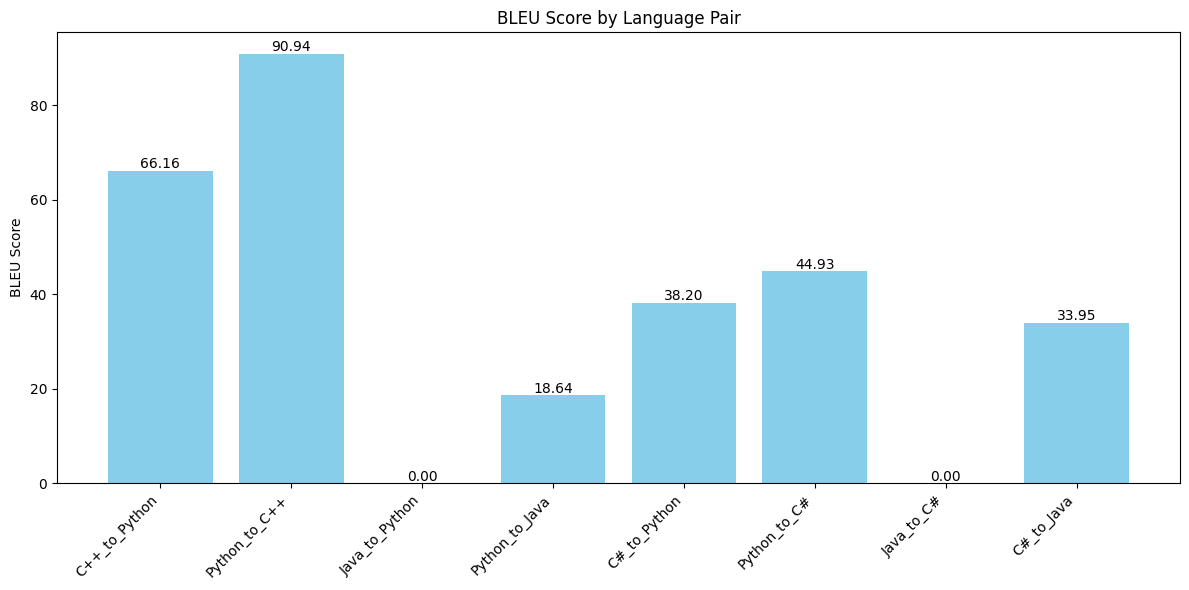

In [22]:
# 必要なライブラリのインストール
!pip install -q transformers bitsandbytes accelerate peft sacrebleu matplotlib pandas

# 必要なインポート
import torch
import gc
import random
import warnings
import re
import os
import json
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel
from google.colab import output, drive


# メモリ解放と最適化の関数
def free_memory():
    torch.cuda.empty_cache()
    gc.collect()

# 警告の非表示と初期メモリ解放
warnings.filterwarnings('ignore', category=UserWarning)
free_memory()

# Colabのウィジェットマネージャーを有効化
output.enable_custom_widget_manager()

# ベースモデル名と量子化設定
base_model_id = "microsoft/phi-4"
lora_model_name = "AkiK/phi-4-4bit-Q-lora-kura-lang-3"

print("モデルとアダプターを読み込んでいます...")

# 4ビット量子化の設定（メモリ効率化）
#bnb_config = BitsAndBytesConfig(
#    load_in_4bit=True,
#    bnb_4bit_quant_type="nf4",
#    bnb_4bit_compute_dtype=torch.bfloat16,
#    bnb_4bit_use_double_quant=True
#)

# デバイスマップの設定
device_map = {
    "": 0,
    "lm_head": 0
}

# モデルとトークナイザーを読み込む
try:
    print("ベースモデルを読み込んでいます...")
    base_model = AutoModelForCausalLM.from_pretrained(
        base_model_id,
        quantization_config=bnb_config,
        device_map=device_map,
        low_cpu_mem_usage=True
    )

    print("トークナイザーを読み込んでいます...")
    tokenizer = AutoTokenizer.from_pretrained(base_model_id, padding_side="left")
    tokenizer.pad_token = tokenizer.eos_token

    print("LoRAアダプターを適用しています...")
    model = PeftModel.from_pretrained(
        base_model,
        lora_model_name,
        is_trainable=False,
        device_map=device_map
    )

    # モデルを評価モードに設定
    model.eval()
    model = model.to('cuda')
    free_memory()

    print("モデルの準備が完了しました")
except Exception as e:
    print(f"モデル読み込みエラー: {e}")
    raise e

# BLEU計算用の関数
def calculate_bleu(predictions, references):
    import sacrebleu
    references_list = [[ref] for ref in references]
    bleu = sacrebleu.corpus_bleu(predictions, references_list)
    return {"bleu": bleu.score}

# 予測と評価の関数（修正版 - 二重サンプリングを防止）
def generate_and_evaluate(model, tokenizer, test_data, num_samples=None, batch_size=4):
    # num_samplesが指定されている場合のみランダムサンプリングを行う
    if num_samples is not None and num_samples < len(test_data):
        random.seed(42)
        test_data = random.sample(test_data, num_samples)

    predictions = []
    references = []

    total_batches = (len(test_data) + batch_size - 1) // batch_size

    print(f"生成開始: {len(test_data)}サンプル, {total_batches}バッチ")

    # バッチ処理
    for i in range(0, len(test_data), batch_size):
        batch_data = test_data[i:i+batch_size]
        batch_prompts = [item["prompt"] for item in batch_data]

        print(f"バッチ {i//batch_size + 1}/{total_batches} 処理中...")

        # バッチでのトークン化
        inputs = tokenizer(
            batch_prompts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        ).to(model.device)

        # バッチでの生成
        with torch.no_grad():
            try:
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=512,
                    temperature=0.2,
                    do_sample=True,
                    top_p=0.95,
                    repetition_penalty=1.1,
                    num_return_sequences=1
                )
            except RuntimeError as e:
                print(f"生成中にエラー: {e}")
                free_memory()
                continue

        # バッチ処理の結果を処理
        for j, output in enumerate(outputs):
            try:
                generated_text = tokenizer.decode(output, skip_special_tokens=True)
                prompt_length = len(batch_data[j]["prompt"])
                predicted_code = generated_text[prompt_length:].strip()

                # コードブロック抽出
                code_markers = ["```python", "```cpp", "```java", "```cs", "```c#", "```"]
                for marker in code_markers:
                    if marker in predicted_code:
                        predicted_code = predicted_code.split(marker)[1].split("```")[0].strip()
                        break

                predictions.append(predicted_code)
                references.append(batch_data[j]["target"])
            except Exception as e:
                print(f"コード抽出中にエラー: {e}")

        # 各バッチ後にメモリを解放
        free_memory()

    # BLEUスコアの計算
    bleu_score = calculate_bleu(predictions, references)
    print(f"生成完了: BLEUスコア {bleu_score['bleu']:.2f}")

    return bleu_score, predictions, references

# テストデータの準備（統合および改善版）
def prepare_test_data():
    """
    テストデータを準備する関数。

    1. 保存済みのJSONファイルからロード
    2. グローバル変数があればそれを使用
    3. 元のデータセットから生成
    4. すべて失敗した場合はエラー

    Returns:
    --------
    list
        テストデータのリスト
    """
    print("テストデータを準備しています...")
    test_data_path = "/content/drive/MyDrive/code_translation_project/test_data.json"

    # 保存先ディレクトリの作成
    os.makedirs(os.path.dirname(test_data_path), exist_ok=True)

    # 1. JSONファイルからのロードを試みる
    if os.path.exists(test_data_path):
        try:
            with open(test_data_path, 'r', encoding='utf-8') as f:
                loaded_data = json.load(f)
                print(f"テストデータをロードしました: {len(loaded_data)}サンプル")

                # 言語ペアごとにグループ化して表示
                pair_groups = {}
                for item in loaded_data:
                    pair = item.get('pair', 'unknown')
                    if pair not in pair_groups:
                        pair_groups[pair] = []
                    pair_groups[pair].append(item)

                if pair_groups:
                    print("言語ペアごとのサンプル数:")
                    for pair, items in pair_groups.items():
                        print(f"  {pair}: {len(items)}サンプル")

                return loaded_data
        except Exception as e:
            print(f"テストデータのロードエラー: {e}")
    else:
        print(f"テストデータファイルが見つかりません: {test_data_path}")

    # 2. グローバル変数にテストデータがある場合はそれを使用
    try:
        if 'test_dataset_with_prompt' in globals() and isinstance(test_dataset_with_prompt, list) and len(test_dataset_with_prompt) > 0:
            print(f"グローバル変数からテストデータを使用します: {len(test_dataset_with_prompt)}サンプル")

            # JSONとして保存しておく
            with open(test_data_path, 'w', encoding='utf-8') as f:
                json.dump(test_dataset_with_prompt, f, ensure_ascii=False)
            print(f"テストデータを {test_data_path} に保存しました")

            return test_dataset_with_prompt
    except Exception as e:
        print(f"グローバル変数からのデータ取得エラー: {e}")

    # 3. 元のデータセットからテストデータを生成
    try:
        if 'test_dataset' in globals() and isinstance(test_dataset, dict) and len(test_dataset) > 0:
            print("元のデータセットからテストデータを生成します...")
            test_data_for_saving = []

            for pair_key, dataset in test_dataset.items():
                for item in dataset:
                    prompt = f"""### Instruction
Translate from {item['source_lang']} to {item['target_lang']}:
{item['source_code']}

### Translation"""

                    test_data_for_saving.append({
                        "prompt": prompt,
                        "target": item['target_code'],
                        "pair": pair_key
                    })

            # JSONとして保存
            with open(test_data_path, 'w', encoding='utf-8') as f:
                json.dump(test_data_for_saving, f, ensure_ascii=False)

            print(f"テストデータを {test_data_path} に保存しました: {len(test_data_for_saving)}サンプル")
            return test_data_for_saving
    except Exception as e:
        print(f"テストデータ生成エラー: {e}")

    # 4. すべての方法が失敗した場合はサンプルデータを使用するか、エラーメッセージを表示
    print("警告: テストデータを取得できませんでした。")
    print("サンプルデータを作成します...")

    # 最小限のサンプルデータを作成
    sample_data = [
        {
            "prompt": """### Instruction
Translate from C++ to Python:
#include <iostream>
int main() {
    std::cout << "Hello, World!" << std::endl;
    return 0;
}

### Translation""",
            "target": """print("Hello, World!")""",
            "pair": "C++_to_Python"
        },
        {
            "prompt": """### Instruction
Translate from Python to C++:
def factorial(n):
    if n == 0 or n == 1:
        return 1
    else:
        return n * factorial(n-1)

print(factorial(5))

### Translation""",
            "target": """#include <iostream>

int factorial(int n) {
    if (n == 0 || n == 1) {
        return 1;
    } else {
        return n * factorial(n-1);
    }
}

int main() {
    std::cout << factorial(5) << std::endl;
    return 0;
}""",
            "pair": "Python_to_C++"
        }
    ]

    # サンプルデータを返す
    print(f"サンプルデータを使用します: {len(sample_data)}サンプル")
    return sample_data

# 言語ペアをプロンプトから抽出する関数
def extract_language_pairs(test_dataset):
    """
    テストデータセットから言語ペアを抽出し、各ペアに対応するインデックスを返す
    """
    pair_indices = {}

    for i, item in enumerate(test_dataset):
        # 既に'pair'キーがある場合はそれを使用
        if 'pair' in item:
            pair_name = item['pair']
            if pair_name not in pair_indices:
                pair_indices[pair_name] = []
            pair_indices[pair_name].append(i)
            continue

        # なければプロンプトから抽出
        prompt = item["prompt"]
        match = re.search(r"Translate from (\w+) to (\w+):", prompt)
        if match:
            source_lang = match.group(1)
            target_lang = match.group(2)
            pair_name = f"{source_lang}_to_{target_lang}"

            if pair_name not in pair_indices:
                pair_indices[pair_name] = []

            pair_indices[pair_name].append(i)

    # 各言語ペアのサンプル数を表示
    print("言語ペアごとのサンプル数:")
    for pair, indices in pair_indices.items():
        print(f"  {pair}: {len(indices)} サンプル")

    return pair_indices

# すべての言語ペアを網羅的に評価するコード
def run_comprehensive_evaluation(model, tokenizer, test_dataset_with_prompt):
    """
    すべての言語ペアについて網羅的に評価するメイン関数
    """
    print("網羅的評価を開始します...")

    # 1. 言語ペアごとのインデックスを抽出
    pair_indices = extract_language_pairs(test_dataset_with_prompt)

    # 2. 評価対象の各言語ペアからサンプルを抽出し、合計100サンプルにする
    total_samples = 100  # 評価するサンプルの合計数
    selected_samples = []
    pair_samples_mapping = {}

    # 言語ペアごとの割り当てサンプル数を計算
    pairs = list(pair_indices.keys())

    if not pairs:
        print("言語ペアが見つかりません。データフォーマットを確認してください。")
        return {"overall": {"bleu": {"bleu": 0}, "num_samples": 0}, "by_language_pair": {}}

    samples_per_pair = max(1, total_samples // len(pairs))
    extra_samples = total_samples - samples_per_pair * len(pairs)

    print(f"言語ペアの数: {len(pairs)}")
    print(f"ペアあたりの基本サンプル数: {samples_per_pair}")

    # 各言語ペアからサンプルを選択
    for i, pair in enumerate(pairs):
        pair_indices_list = pair_indices[pair]

        # 割り当てるサンプル数（余りをいくつかのペアに追加）
        pair_sample_count = samples_per_pair + (1 if i < extra_samples else 0)
        pair_sample_count = min(pair_sample_count, len(pair_indices_list))

        # サンプルをランダムに選択
        if pair_sample_count > 0:
            selected_indices = random.sample(pair_indices_list, pair_sample_count)
            pair_samples = [test_dataset_with_prompt[idx] for idx in selected_indices]

            # 選択したサンプルを記録
            pair_samples_mapping[pair] = {
                "samples": pair_samples,
                "indices": selected_indices,
                "count": pair_sample_count
            }
            selected_samples.extend(pair_samples)

            print(f"  {pair}: {pair_sample_count}サンプル選択")

    if not selected_samples:
        print("選択されたサンプルがありません。")
        return {"overall": {"bleu": {"bleu": 0}, "num_samples": 0}, "by_language_pair": {}}

    print(f"合計 {len(selected_samples)} サンプルを評価します")

    # 3. 選択したサンプルで全体の評価を実行
    overall_bleu, all_predictions, all_references = generate_and_evaluate(
      model,
      tokenizer,
      selected_samples,
      num_samples=None,  # サンプリングを無効化（すでに選択済み）
      batch_size=4
    )

    # 4. 言語ペアごとの評価結果をまとめる
    pair_results = {}
    prediction_idx = 0

    for pair, data in pair_samples_mapping.items():
        pair_count = data["count"]
        if pair_count == 0:
            continue

        # この言語ペアの予測と参照を抽出
        pair_predictions = all_predictions[prediction_idx:prediction_idx + pair_count]
        pair_references = all_references[prediction_idx:prediction_idx + pair_count]
        pair_samples = data["samples"]

        # BLEUスコアを計算
        if pair_predictions and pair_references:
            pair_bleu = calculate_bleu(pair_predictions, pair_references)

            # サンプル例を保存
            examples = {}
            if pair_predictions:
                examples = {
                    "first": {
                        "prompt": pair_samples[0]["prompt"] if pair_samples else "",
                        "prediction": pair_predictions[0] if pair_predictions else "",
                        "reference": pair_references[0] if pair_references else ""
                    }
                }

                if len(pair_predictions) > 1:
                    examples["last"] = {
                        "prompt": pair_samples[-1]["prompt"] if pair_samples else "",
                        "prediction": pair_predictions[-1] if pair_predictions else "",
                        "reference": pair_references[-1] if pair_references else ""
                    }

            # 結果を保存
            pair_results[pair] = {
                "bleu": pair_bleu,
                "num_samples": pair_count,
                "examples": examples
            }
        else:
            print(f"警告: {pair} のサンプルがありません")

        prediction_idx += pair_count

    # 5. 評価結果をまとめる
    results = {
        "overall": {
            "bleu": overall_bleu,
            "num_samples": len(all_predictions)
        },
        "by_language_pair": pair_results
    }

    # 6. 結果を可視化して保存
    visualize_and_save_results(pair_results)

    return results

# 結果を可視化して保存する関数
def visualize_and_save_results(pair_results):
    """評価結果を可視化してファイルに保存"""
    import matplotlib.pyplot as plt
    import pandas as pd

    # 保存先ディレクトリの作成
    save_dir = '/content/drive/MyDrive/code_translation_project/evaluation_results'
    os.makedirs(save_dir, exist_ok=True)

    # タイムスタンプを付けたファイル名
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # BLEUスコアを抽出
    bleu_data = {
        pair: result["bleu"]["bleu"]
        for pair, result in pair_results.items()
    }

    # サンプル数を取得
    sample_counts = {
        pair: result["num_samples"]
        for pair, result in pair_results.items()
    }

    # 結果をCSVに保存
    csv_data = {
        'BLEU': bleu_data,
        'Samples': sample_counts
    }
    df = pd.DataFrame(csv_data)
    csv_path = os.path.join(save_dir, f"bleu_scores_{timestamp}.csv")
    df.to_csv(csv_path)
    print(f"BLEUスコアを {csv_path} に保存しました")

    # グラフを作成して保存
    plt.figure(figsize=(12, 6))

    pairs = list(bleu_data.keys())
    scores = list(bleu_data.values())

    plt.bar(pairs, scores, color='skyblue')
    plt.ylabel('BLEU Score')
    plt.title('BLEU Score by Language Pair')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # スコアを棒グラフの上に表示
    for i, score in enumerate(scores):
        plt.text(i, score + 0.5, f"{score:.2f}", ha='center')

    # グラフを保存
    graph_path = os.path.join(save_dir, f"bleu_graph_{timestamp}.png")
    plt.savefig(graph_path)
    print(f"グラフを {graph_path} に保存しました")

    # 結果をJSONに保存
    json_path = os.path.join(save_dir, f"full_results_{timestamp}.json")

    # JSON形式で保存できる形に変換
    serializable_results = {}
    for pair, result in pair_results.items():
        serializable_results[pair] = {
            "bleu": result["bleu"]["bleu"],
            "num_samples": result["num_samples"],
            "examples": result["examples"]
        }

    with open(json_path, 'w', encoding='utf-8') as f:
        json.dump(serializable_results, f, ensure_ascii=False, indent=2)

    print(f"詳細な結果を {json_path} に保存しました")

# メイン処理
try:
    # テストデータを準備
    test_dataset_with_prompt = prepare_test_data()

    # 包括的な評価を実行
    results = run_comprehensive_evaluation(
        model, tokenizer, test_dataset_with_prompt
    )

    # 全体のBLEUスコア
    print(f"\n全体のBLEUスコア: {results['overall']['bleu']['bleu']:.2f}")

    # 言語ペアごとのBLEUスコア
    print("\n言語ペアごとのBLEUスコア:")
    for pair, result in results["by_language_pair"].items():
        print(f"  {pair}: {result['bleu']['bleu']:.2f} ({result['num_samples']} サンプル)")

except Exception as e:
    print(f"評価中に致命的なエラーが発生: {e}")
    import traceback
    traceback.print_exc()
finally:
    free_memory()